In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.observables import nrmse, rsquare

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt

def forced_van_der_pol(t, z, mu, A, omega):
    x, y, s_current = z  # Unpack the values
    dxdt = y
    dydt = mu * (1 - x**2) * y - x + A * np.sin(omega * t)
    s = np.sin(omega * t)
    return [dxdt, dydt, s]

mu = 1.0
A = 1.0
omega = 1.0
initial_state = [1.0, 0.0, 0.0]
t_span = (0, 2510)

sol = solve_ivp(forced_van_der_pol, t_span, initial_state, args=(mu, A, omega), dense_output=True, t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step = 0.01)

t = sol.t
z = sol.y

# CSVファイルにデータを保存
data = pd.DataFrame({'Time': t, 'x': z[0], 'y': z[1], 'sin':z[2]})
data.to_csv('forced_vanderpol_dataset.csv', index=False)

data_withouttime = pd.DataFrame({'x': z[0], 'y': z[1], 'sin':z[2]})


# CSVファイルを読み込む
data_loaded = pd.read_csv('forced_vanderpol_dataset.csv')

X = data_withouttime.values

X.shape

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.99516982, -0.0948686 ,  0.00499623],
       [ 0.98137902, -0.17915274,  0.01993501],
       ...,
       [ 2.12176035,  1.56656147,  1.94521682],
       [ 2.24443515,  0.91342993,  1.97308553],
       [ 2.3101345 ,  0.4283908 ,  1.99123072]])

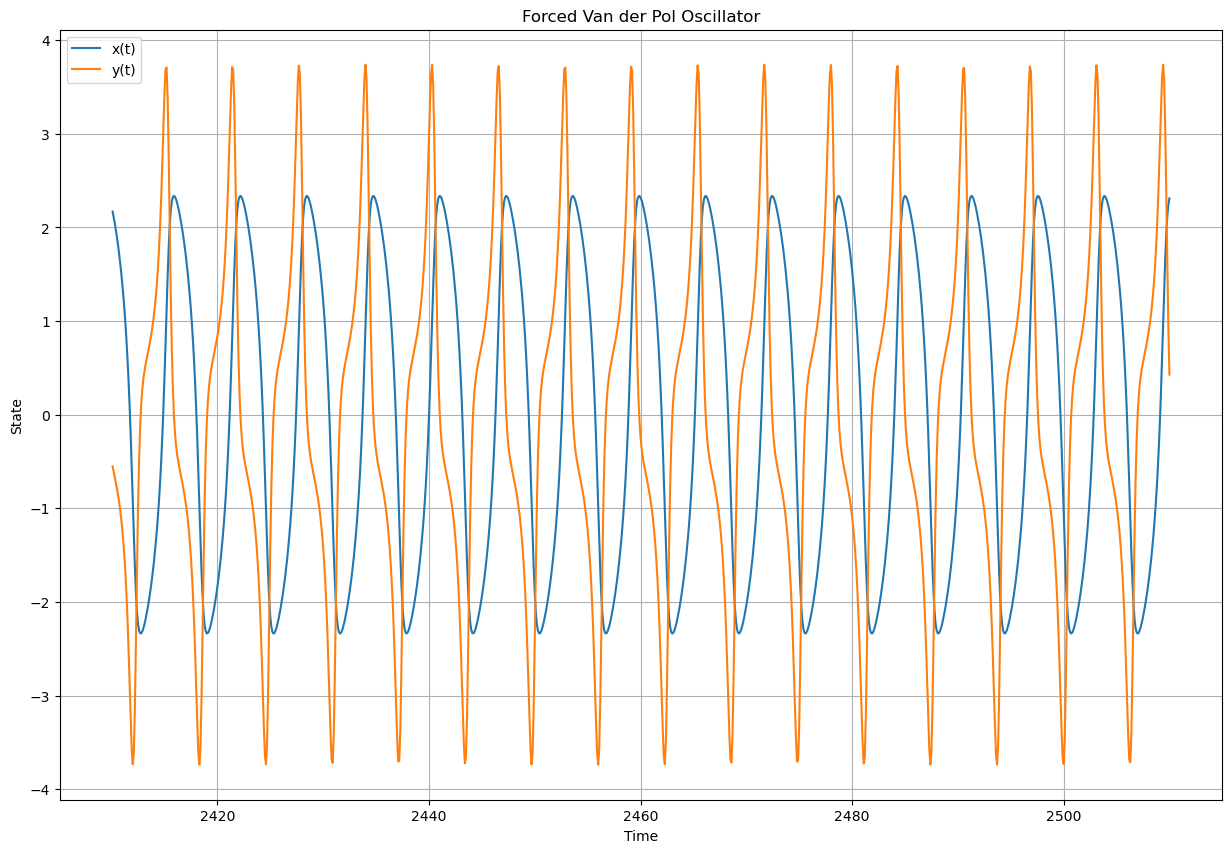

In [3]:
# データをプロット
plt.figure(figsize=(15, 10))
plt.plot(data_loaded['Time'][-1000:], data_loaded['x'][-1000:], label='x(t)')
plt.plot(data_loaded['Time'][-1000:], data_loaded['y'][-1000:], label='y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.grid()
plt.title('Forced Van der Pol Oscillator')
plt.show()

In [4]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [5]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [6]:
from reservoirpy.datasets import to_forecasting

train_len = 3000
test_len = 4000

x, y = to_forecasting(X, forecast=10)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [7]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [06:09<00:00,  1.85s/trial, best loss: 1.1344471281389074e-06]


In [8]:
best

({'N': 0,
  'iss': 0.8644046911873131,
  'lr': 0.6156368875066843,
  'ridge': 8.186416440991658e-08,
  'seed': 0,
  'sr': 1.6722388684853167},
 <hyperopt.base.Trials at 0x28d73dc40>)

In [9]:
# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.8644046911873131
lr = 0.6156368875066843
ridge = 8.186416440991658e-08
seed = 1234
sr = 1.6722388684853167

In [10]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [11]:
# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_test)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_test, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 1.5473293890429841e-06
R^2: 0.9999999999461235


In [12]:
predictions

array([[-1.50003343, -3.35366067,  0.16403046],
       [-1.8050735 , -2.70809094,  0.1134185 ],
       [-2.03727816, -1.93120977,  0.07166597],
       ...,
       [ 2.31557782, -0.26258086,  1.98835362],
       [ 2.28340904, -0.37479512,  1.96822853],
       [ 2.24156169, -0.45857144,  1.93842411]])

In [13]:
y_test

array([[-1.50003026, -3.35368212,  0.16403214],
       [-1.80507431, -2.7081166 ,  0.11342023],
       [-2.03728325, -1.93119269,  0.07166744],
       ...,
       [ 2.31558234, -0.26259059,  1.98835552],
       [ 2.28340554, -0.37480558,  1.96822598],
       [ 2.24155868, -0.45857096,  1.93842147]])

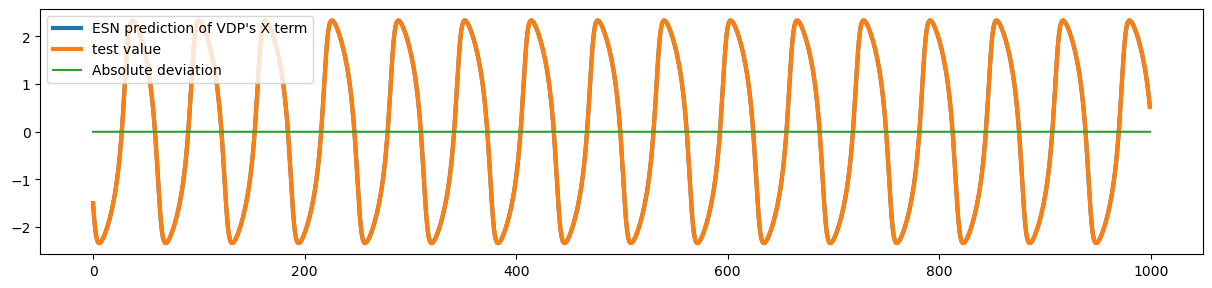

In [14]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, :1][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, :1][:sample] - predictions[:, :1][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

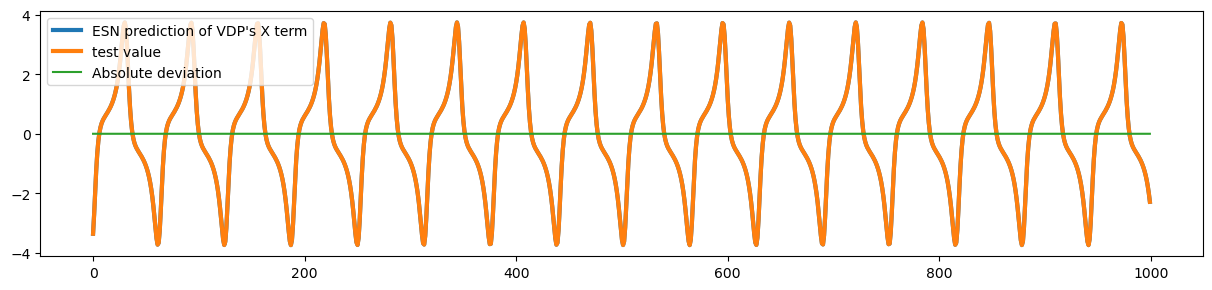

In [15]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

### Generative Modelを使ってみる

そもそも誤差がかなり小さいのだから、Generative Modelも序盤は良い振る舞いを見せると予想する。

In [16]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()

In [17]:
esn = reset_esn()

x, y = to_forecasting(X, forecast=1)
X_train3, y_train3 = x[:2000], y[:2000]
X_test3, y_test3 = x[2000:], y[2000:]

esn = esn.fit(X_train3, y_train3)

seed_timestepsとnb_generationsの差は一定じゃないといけない？

In [18]:
seed_timesteps = 100

warming_inputs = X_test3[:seed_timesteps]

warming_out = esn.run(warming_inputs, reset=True)  # warmup

In [19]:
nb_generations = 400

X_gen = np.zeros((nb_generations, 3))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = esn(y)
    X_gen[t, :] = y

In [26]:
warming_inputs

array([[ 1.31181416e-01, -2.81660699e+00,  5.05869044e-01],
       [-1.69552931e-01, -3.19769243e+00,  4.21540468e-01],
       [-5.07094264e-01, -3.53839316e+00,  3.42992128e-01],
       [-8.72288355e-01, -3.72898727e+00,  2.71008917e-01],
       [-1.24350878e+00, -3.63932466e+00,  2.06310123e-01],
       [-1.58847872e+00, -3.20399447e+00,  1.49542247e-01],
       [-1.87533814e+00, -2.50293483e+00,  1.01272541e-01],
       [-2.08655717e+00, -1.72504848e+00,  6.19833377e-02],
       [-2.22355865e+00, -1.03939252e+00,  3.20672329e-02],
       [-2.30002004e+00, -5.18285809e-01,  1.18231623e-02],
       [-2.33250931e+00, -1.54896432e-01,  1.45341417e-03],
       [-2.33497360e+00,  8.92552526e-02,  1.06160783e-03],
       [-2.31730398e+00,  2.53665286e-01,  1.06516584e-02],
       [-2.28588386e+00,  3.68379889e-01,  3.01277376e-02],
       [-2.24460045e+00,  4.53590529e-01,  5.92952314e-02],
       [-2.19571219e+00,  5.22143195e-01,  9.78626847e-02],
       [-2.14045162e+00,  5.82081756e-01

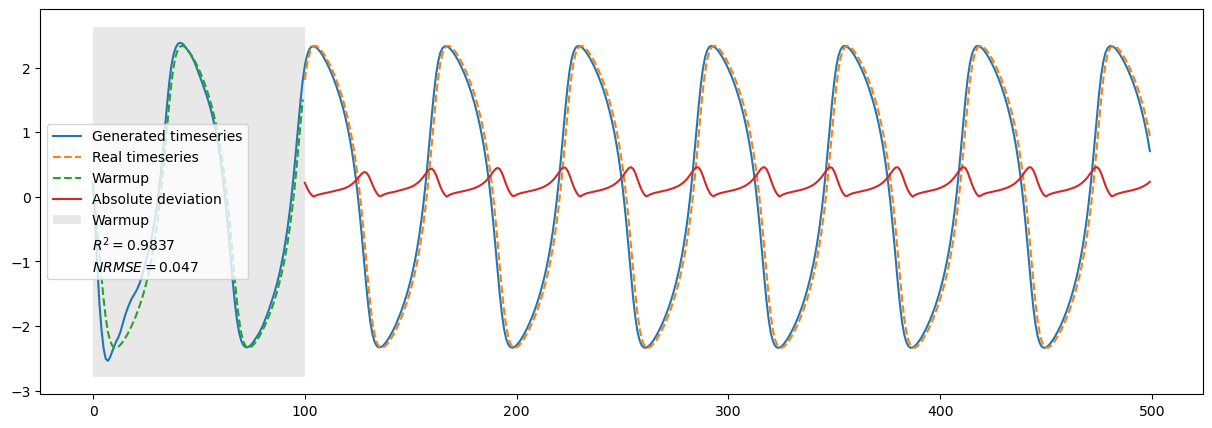

In [20]:
X_t = X_test3[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen[:, :1], X_t[:, :1], nb_generations, warming_out=warming_out[:, :1],
                warming_inputs=warming_inputs[:, :1], seed_timesteps=seed_timesteps)

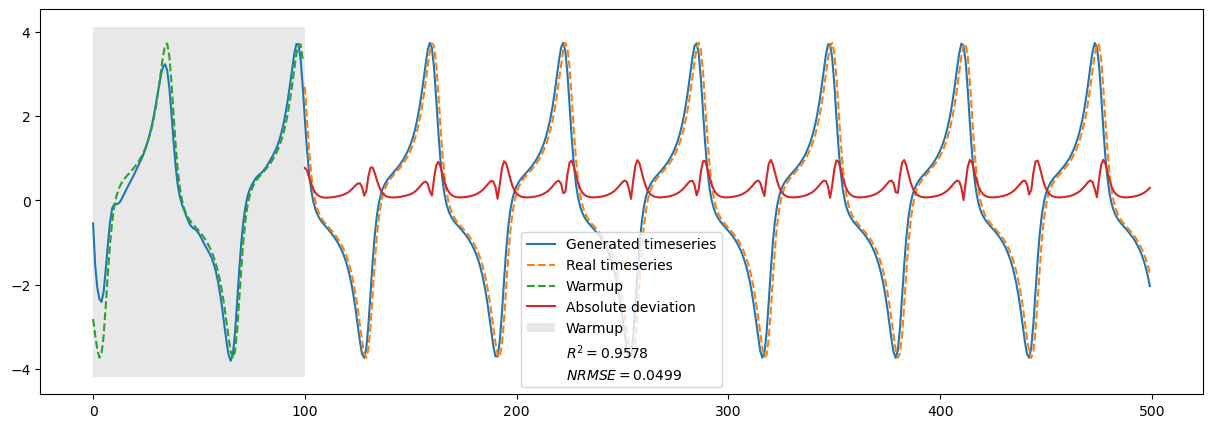

In [21]:
X_t = X_test3[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen[:, 1:2], X_t[:, 1:2], nb_generations, warming_out=warming_out[:, 1:2],
                warming_inputs=warming_inputs[:, 1:2], seed_timesteps=seed_timesteps)


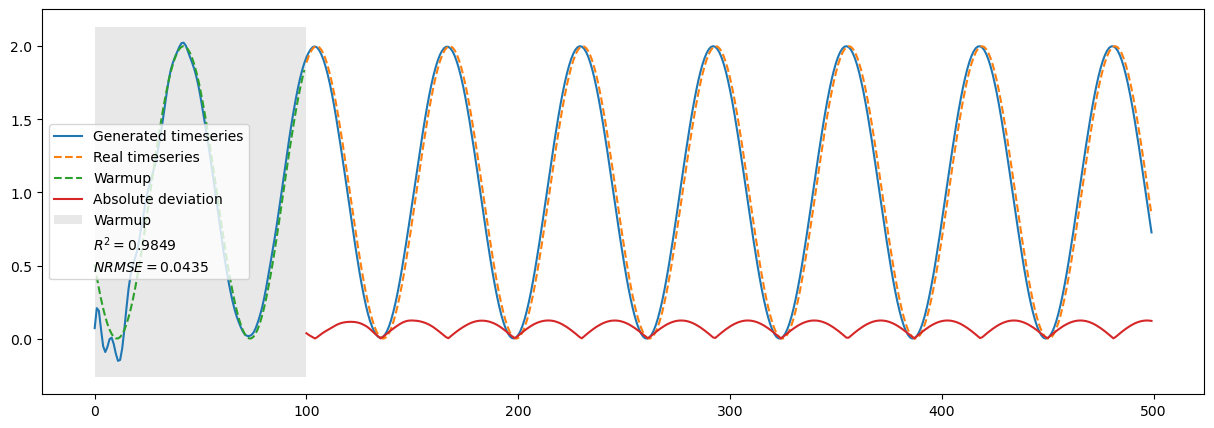

In [22]:
X_t = X_test3[seed_timesteps: nb_generations+seed_timesteps]
plot_generation(X_gen[:, 2:3], X_t[:, 2:3], nb_generations, warming_out=warming_out[:, 2:3],
                warming_inputs=warming_inputs[:, 2:3], seed_timesteps=seed_timesteps)


周期外力の場合は、高精度に予測できていることがわかる。
1期先しか予測できないのか？